## Table of Contents
- [1 - Problem statement](#1)
- [2 - Import useful libraries](#2)
- [3 - Loading Dataset](#3)

    - [example 1](#ex-1)

<a name='1'></a>
## 1 - Problem Statement
The dataset is provided by 
You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.

Task:
Given a person’s credit-related information, build a machine learning model that can classify the credit score.

<a name='2'></a>
## 2 - Import useful libraries ##

In [ ]:
# standard libraries
import numpy as np 
import pandas as pd 

# time libraries 
from tqdm import tqdm
from time import time

# visualization library
import umap.umap_ as UMAP

# resampling libraries
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler

# useful library
from collections import Counter

# scikit-learn libraries for preprocessing and report analysis 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix

# tensorflow libraries for Neural Network implementation
import tensorflow as tf
from tensorflow.keras import Sequential, initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# library for hyperparameters tuning
import keras_tuner as kt

# standard plot library
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<a name='3'></a>
## 3 - Loading and Data description ##
Dataset 27 features and 1 target, for a total of $10^6$ instances. 
* <span style="color:blue">**blue**</span> $\rightarrow$ redundant features
* <span style="color:red">**red**</span> $\rightarrow$ features with wrong data type
* <span style="color:green">**green**</span> $\rightarrow$ target
* (#) $\rightarrow$ numerical feature
* (A) $\rightarrow$ categorical feature

1. (<span style="color:blue">**A**</span>) **ID**: Represents a unique identification of an entry;
2. (A) **Customer_ID**: Represents a unique identification of a person;
3. (A) **Month**: Represents the month of the year;
4. (<span style="color:blue">**A**</span>) **Name**: Represents the name of a person;
5. (<span style="color:red">**A**</span>) **Age**: Represents the age of the person;
6. (<span style="color:blue">**A**</span>) **SSN**: Represents the social security number of a person;
7. (A) **Occupation**: Represents the occupation of the person;
8. (<span style="color:red">**A**</span>) **Annual_Income**: Represents the annual income of the person;
9. (#) **Monthly_Inhand_Salary**: Represents the monthly base salary of a person;
10. (#) **Num_Bank_Accounts**: Represents the number of bank accounts a person holds;
11. (#) **Num_Credit_Card**: Represents the number of other credit cards held by a person;
12. (#) **Interest_Rate**: Represents the interest rate on credit card;
13. (<span style="color:red">**A**</span>) **Num_of_Loan**: Represents the number of loans taken from the bank;
14. (A) **Type_of_Loan**: Represents the types of loan taken by a person;
15. (#) **Delay_from_due_date**: Represents the average number of days delayed from the payment date;
16. (<span style="color:red">**A**</span>) **Num_of_Delayed_Payment**: Represents the average number of payments delayed by a person;
17. (#) **Changed_Credit_Limit**: Represents the percentage change in credit card limit;
18. (#) **Num_Credit_Inquiries**: Represents the number of credit card inquiries;
19. (A) **Credit_Mix**: Represents the classification of the mix of credits;
20. (<span style="color:red">**A**</span>) **Outstanding_Debt**: Represents the remaining debt to be paid (in USD);
21. (#) **Credit_Utilization_Ratio**: Represents the utilization ratio of credit card;
22. (<span style="color:red">**A**</span>) **Credit_History_Age**: Represents the age of credit history of the person;
23. (A) **Payment_of_Min_Amount**: Represents whether only the minimum amount was paid by the person;
24. (#) **Total_EMI_per_month**: Represents the monthly EMI payments (in USD);
25. (<span style="color:red">**A**</span>) **Amount_invested_monthly**: Represents the monthly amount invested by the customer (in USD);
26. (A) **Payment_Behaviour**: Represents the payment behavior of the customer (in USD);
27. (#) **Monthly_Balance**: Represents the monthly balance amount of the customer (in USD);
28. (<span style="color:green">**A**</span>) **Credit_Score**: Represents the bracket of credit score (Poor, Standard, Good).

In [ ]:
# low_memory=False because it has 26 columns with mixed types
df = pd.read_csv("../Data/train.csv", low_memory=False)

# Remove redundant features,
# 'Customer_ID' is left on for preprocessing analysis, after that 
# it is dropped
df.drop(columns=['ID', 'Name', 'SSN'], inplace=True)

n_rows, n_cols = df.shape
print(f'Dataset shape: {n_rows, n_cols}')

n1 = 12
print(f'First {n1} columns')
df.iloc[:, :n1].head(8)

In [ ]:
print(f'Last {n_cols - n1} columns')
df.iloc[:, n1:].head(8)

In [ ]:
import pandas_profiling as pp
#pp.ProfileReport(df, title = 'Pandas Profiling report of "dataset"', html = {'style':{'full_width': True}})

<a name='4'></a>
## 4 - Clean the dataset ##
Replace with NaN values the artifacts in the features 'Monthly_Balance', 'Amount_invested_monthly', and 'Payment_Behaviour'.

In [ ]:
artifacts = ['__-333333333333333333333333333__', '__10000__', '!@9#%8']
df.replace(artifacts, np.nan, inplace=True)

For the 'Credit_History_Age' feature, the years and months are coded as total months, then the variable is casted as numeric.

In [ ]:
df.loc[df.Credit_History_Age.notna(),
       'Credit_History_Age'] = df['Credit_History_Age'].str.extractall('(\d+)').unstack().astype(float).multiply([12, 1]).sum(axis=1)
df['Credit_History_Age'] = df['Credit_History_Age'].astype(float)

df.iloc[:, n1:].head()

We can show that all missing values of 'Type_of_Loan' corresponds to 'Num_of_Loan' = 0. So we indicate that values with 'no Loan'. 
Previously we made dummy variables for whether each of the 10 possible loan types were represented in the row. This turned out to reduce the accuracy of the model by $15\%$.

In [ ]:
df['Type_of_Loan'].fillna('no Loan', inplace=True)
df['Type_of_Loan'].value_counts()[:10]

Remove the '_' character to cast the wrong assigned categorical features into numerical features.

In [ ]:
# Categorical features
cat = df.drop(columns=['Credit_Score',
                       'Customer_ID']).select_dtypes(include=["object"]).columns

# Find all the categorical features which contain the character '_'  
features_ = [feature for feature in cat if df[feature].str.contains('_').any()]

# Remove the character '_' from all the selected categorical features
for feature in features_:
    df[feature] = df[feature].str.replace("_", "")


# All the wrong assigned categorical features
features_wac = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
            'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
            'Monthly_Balance', 'Total_EMI_per_month']

# Casting the features as numeric
for feature in features_wac:
    df[feature] = pd.to_numeric(df[feature]).astype('float')


# Correct categorical features.   
cat = df.drop(columns=['Credit_Score',
                       'Customer_ID']).select_dtypes(include=["object"]).columns   
# Numeric features 
num = df.select_dtypes(include=["number"]).columns


# Let's take a copy of the dataframe to backup some data
df_old = df.copy()

<a name='5'></a>
## 5 - Outlier Detection ##
We have considered the box plot of all the features in order to detect outliers in the dataset.

In [ ]:
%matplotlib inline
def box_plot_utility(df):
    fig, axs = plt.subplots(2, 6, figsize=(15, 5), constrained_layout=True)

    for col, ax in zip(num[:12], axs.flatten()):
        sns.boxplot(data=df[col], ax=ax)
        ax.set_title(col)
    plt.show()

    fig, axs = plt.subplots(1, 5, figsize=(12.7, 2.5), constrained_layout=True)
    for col, ax in zip(num[12:], axs.flatten()):
        sns.boxplot(data=df[col], ax=ax)
        ax.set_title(col)
        
box_plot_utility(df)   

We can see that most features have outliers, but we can show that most data can be quickly restored by substituting the mode value for each Customer_ID. 

In [ ]:
from statistics import mode

features_tmp = ['Age','Annual_Income', 'Num_Bank_Accounts', 'Occupation',
                'Num_Credit_Card', 'Num_of_Loan', 'Interest_Rate',
                'Outstanding_Debt']

for feature in features_tmp:
    tmp = df[['Customer_ID',
               feature]].groupby('Customer_ID')[feature].apply(mode)
    df[feature] = df['Customer_ID'].map(tmp.to_dict())


# Restore back the 'Occupation' values where the algorithm fail
customers_wrong = df.loc[df.Occupation == '', 'Customer_ID'].unique()
for customer in customers_wrong:
    df.loc[df.Customer_ID == customer,
           'Occupation'] = df_old.loc[df_old.Customer_ID == customer,
                                      'Occupation'].unique()[1]


# Restore back the 'Num_Credit_Card' values where the algorithm fail
tmp_num_cc = df_old.loc[df_old['Num_Bank_Accounts'] == -1,
                        'Num_Credit_Card']
tmp_num_cc.loc[55636] = 4
df.loc[tmp_num_cc.index, 'Num_Credit_Card']


# Set to NaN values some typos 
df.loc[df['Num_Credit_Inquiries'] > 20, 'Num_Credit_Inquiries'] = np.nan
df.loc[df['Num_of_Delayed_Payment'] > 30, 'Num_of_Delayed_Payment'] = np.nan


# Drop the unuseful column Customer_ID
df.drop(columns='Customer_ID', inplace=True)

We can see how the 

In [ ]:
box_plot_utility(df)   

<a name='6'></a>
## 6 - Model and visualization ##

### Splitting up the data ###
The data is split into Training, Validation, and Test sets, with 60%, 20%, and 20% percentages, respectively.

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df.drop(columns=["Credit_Score"]),
    df["Credit_Score"],
    test_size= 0.20,
    shuffle=True
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size= 0.25,
    random_state= 42,
    shuffle=True
    )

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((60000, 23), (20000, 23), (20000, 23))

### Data preparation ###
#### Imbalanced learning ####
As the data is somewhat imbalanced, RandomOverSampler is used to generate new datapoints of the least represented target values. This allowed us to get the same number of points for each class.

#### Onehot-encoding ####
The categorical features are one hot encoded to features giving "1" or "0" for each possible category. This heavily increases the dimensionality of the data, mostly due to the feature "Type_of_Loan", which has over 6000 categories. This feature has, however, proven to be crucial for the accuracy of the model. This can be explained by the fact that the bank could be interested not only in the type of loan but also in the order in which they are stipulated.

#### Feature scaling ####
To improve the chances of converging during training, the data is scaled by MaxAbsScaler.

In [ ]:
# Oversampling due to imbalance
sampler = RandomOverSampler() 

X_train, y_train = sampler.fit_resample(X_train, y_train)


# Making a pipeline for transforming

cat_preprocessor = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent")),
     ("onehot", OneHotEncoder(sparse=True, handle_unknown="ignore"))]
    )

num_preprocessor = Pipeline(
    [("imputer", SimpleImputer(strategy="median"))]
    )  

preprocessor = ColumnTransformer(
    [("categorical", cat_preprocessor, cat), 
    ("numerical", num_preprocessor, num)]
    )

    
# Transforming
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


# Scaling
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train).toarray()
X_val = scaler.transform(X_val).toarray()
X_test = scaler.transform(X_test).toarray()

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
sorted(Counter(y_train).items())

[(0, 31868), (1, 31868), (2, 31868)]

#### Visualization ####
The testing dataset is used for training a UMAP visualization of the data's clusters. We can see that although the Credit Scores are somewhat intertwined, especially for Credit Scores closer to each other (Standard & Good, Poor & Standard), the algorithm finds clear clusters. It is especially hard for the algorithm to differ Good from other credit scores, as can be seen in the bottom left clusters.

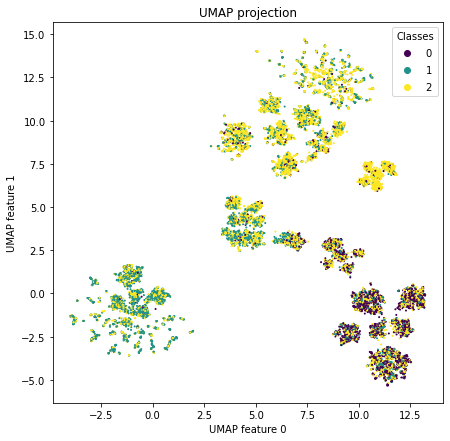

In [160]:
reducer = UMAP.UMAP(15)
embedding = reducer.fit_transform(X_test)

le = LabelEncoder()

plt.figure(figsize=(7, 7))
scatter = plt.scatter(embedding[:, 0],embedding[:, 1],  s=1, c=y_test)
plt.xlabel('UMAP feature 0')
plt.ylabel('UMAP feature 1')
plt.title('UMAP projection')
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")

plt.show()

#### Neural Network ####
To find the best hyper parameters, a different neural networks are tested by a Keras Tuner. The tuner test all combinations of the following:

* Number of hidden layers: [1, 3],
* Number of neurons per layer: [250, 500],
* Learning rates: [0.01, 0.001],
* A dropout layer with 0.8 as dropout rate is added before the output layer in order to reduce overfitting.

In [ ]:
initializer = initializers.HeNormal()

def build_model(hp):
    model = Sequential(name='Credit_Score_classification')
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(
            Dense(
                units=hp.Int(f'units_{i}', min_value=250, max_value=500,  step=250), 
                activation='relu', 
                name=f'L{i}'
                )
            )
        
    #model.add(BatchNormalization())
    model.add(Dropout(0.8, seed=123))
        
    model.add(
        Dense(
            3, kernel_initializer=initializer, activation='softmax', name=f'L{i+1}')
        )
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lrate', values=[1e-2, 1e-3])),
        loss=SparseCategoricalCrossentropy,
        metrics=['accuracy']
        )
    
    return model

### Tune the model architecture
In the function above is defined the search space for which perform the Random Search.

<center>
<img src="../images/Random vs Grid.jpeg" style="width:720px;height:350px;">
<caption><center> <u> <font color='black'> <b>Figure 1</b> </u><font color='black'>  : <b>Grid Search vs Random Search</b><br> The Random Search is a variation of the Grid Search algorithm, which randomly samples the search space instead of discretizing it with a Cartesian grid. The algorithm has no end. Instead a time budget has to be specified (i.e. a number of trials). This algorithm suffers likewise from the curse of dimensionality to reach a preset fixed sampling density. One of the advantages of random search is that if two hyper-parameters are little correlated, random search enables to find more precisely the optima of each parameter. </center></caption>

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=50,
    directory='keras_tuner',
    project_name="Credit_Score_classification",
    overwrite=True
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[callback]
    )

Trial 42 Complete [00h 01m 11s]
val_accuracy: 0.7246000170707703

Best val_accuracy So Far: 0.7631999850273132
Total elapsed time: 00h 55m 33s


In [ ]:
model = tuner.get_best_models()[0]
model.summary()

Model: "Credit_Score_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
L0 (Dense)                   (None, 500)               3156500   
_________________________________________________________________
L1 (Dense)                   (None, 250)               125250    
_________________________________________________________________
L2 (Dense)                   (None, 250)               62750     
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
L3 (Dense)                   (None, 3)                 753       
Total params: 3,345,253
Trainable params: 3,345,253
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)


result = tf.math.confusion_matrix(y_test, y_pred)
print(result)

tf.Tensor(
[[4922  701  260]
 [1609 7711 1319]
 [  94  771 2613]], shape=(3, 3), dtype=int32)


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      5883
           1       0.84      0.72      0.78     10639
           2       0.62      0.75      0.68      3478

    accuracy                           0.76     20000
   macro avg       0.74      0.77      0.75     20000
weighted avg       0.77      0.76      0.76     20000

